## Setup

Tutorial from here: https://langchain-ai.github.io/langgraph/tutorials/sql-agent/#define-tools-for-the-agent

First, execute imports and load API key, select LLM

In [2]:
import os
import requests
from typing import Any, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from utils import load_certs
from langchain_core.messages import ToolMessage, AIMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages

load_dotenv()
load_certs()

Load sample database, store locally. Query some records

In [3]:
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
model_deployment = os.getenv("AZURE_GPT4_DEPLOYMENT")

db_file = "Chinook.db"
if not os.path.exists(db_file):
    response = requests.get(url)
    if response.status_code == 200:
        # Open a local file in binary write mode
        with open("Chinook.db", "wb") as file:
            # Write the content of the response (the file) to the local file
            file.write(response.content)
        print(f"File downloaded and saved as {db_file}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File was already downloaded: {db_file}")

db = SQLDatabase.from_uri(f"sqlite:///{db_file}")
print(f"Tables: {db.get_usable_table_names()}")
db.run("SELECT * FROM Artist LIMIT 10;")

File was already downloaded: Chinook.db
Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## Utility Functions

We will define a few utility functions to help us with the agent implementation. Specifically, we will wrap a ToolNode with a fallback to handle errors and surface them to the agent.

In [4]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.
- list_tables_tool: Fetch the available tables from the database
- get_schema_tool: Fetch the DDL for a table
- db_query_tool: Execute the query and fetch the results OR return an error message if the query fails

In [5]:
toolkit = SQLDatabaseToolkit(db=db, llm=AzureChatOpenAI(model=model_deployment))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
print(list_tables_tool.invoke(""))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track


In [6]:
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
print(get_schema_tool.invoke("Artist"))


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [7]:
@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


We also define function (a chain actually) to verify a SQL query for syntactical correctness

In [8]:
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | AzureChatOpenAI(model=model_deployment, temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

check_answer = query_check.invoke({"messages": [("user", "SELEKT top 10 * FROOM Artist;")]})
print(check_answer.tool_calls[0]["args"]["query"])

SELECT * FROM Artist LIMIT 10;


## Define the workflow

We will then define the workflow for the agent. The agent will first force-call the list_tables_tool to fetch the available tables from the database, then follow the steps mentioned at the beginning of the tutorial.

In [9]:
# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a new graph
workflow = StateGraph(State)

# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = AzureChatOpenAI(model=model_deployment, temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")

    # Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | AzureChatOpenAI(model=model_deployment, temperature=0).bind_tools(
    [SubmitFinalAnswer]
)

def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

## Visualize the graph

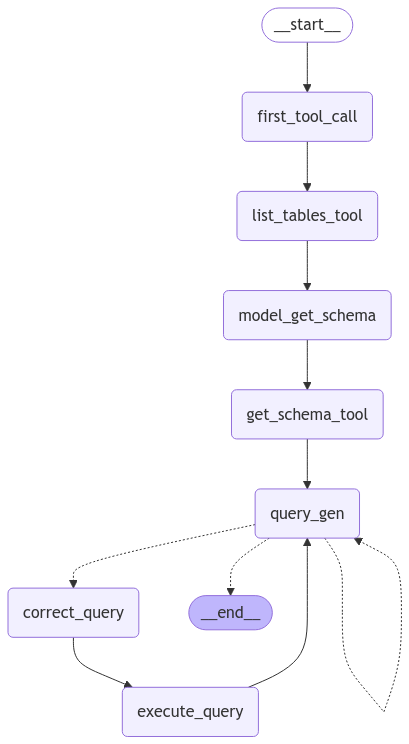

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run the agent

In [11]:
messages = app.invoke(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
print(json_str)

for event in app.stream(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
):
    print(event)

The sales agent who made the most in sales in 2009 is Nancy Edwards.
{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='297ccf05-963a-435b-bda9-b1f9f2b8ca36', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='4707d504-db5b-4237-9ea2-b783e848018d', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WEt7mx79SOFvQIok4L6xYQL8', 'function': {'arguments': '{\n  "table_names": "Employee, Invoice"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 175, 'total_tokens': 194, 'completion_tokens_details': None, 'prompt_toke

## Evaluation

Now, we can evaluate this agent! We previously defined simple SQL agent as part of our LangSmith evaluation cookbooks, and evaluated responses to 5 questions about our database. We can compare this agent to our prior one on the same dataset. Agent evaluation can focus on 3 things:

- Response: The inputs are a prompt and a list of tools. The output is the agent response.
- Single tool: As before, the inputs are a prompt and a list of tools. The output the tool call.
- Trajectory: As before, the inputs are a prompt and a list of tools. The output is the list of tool calls

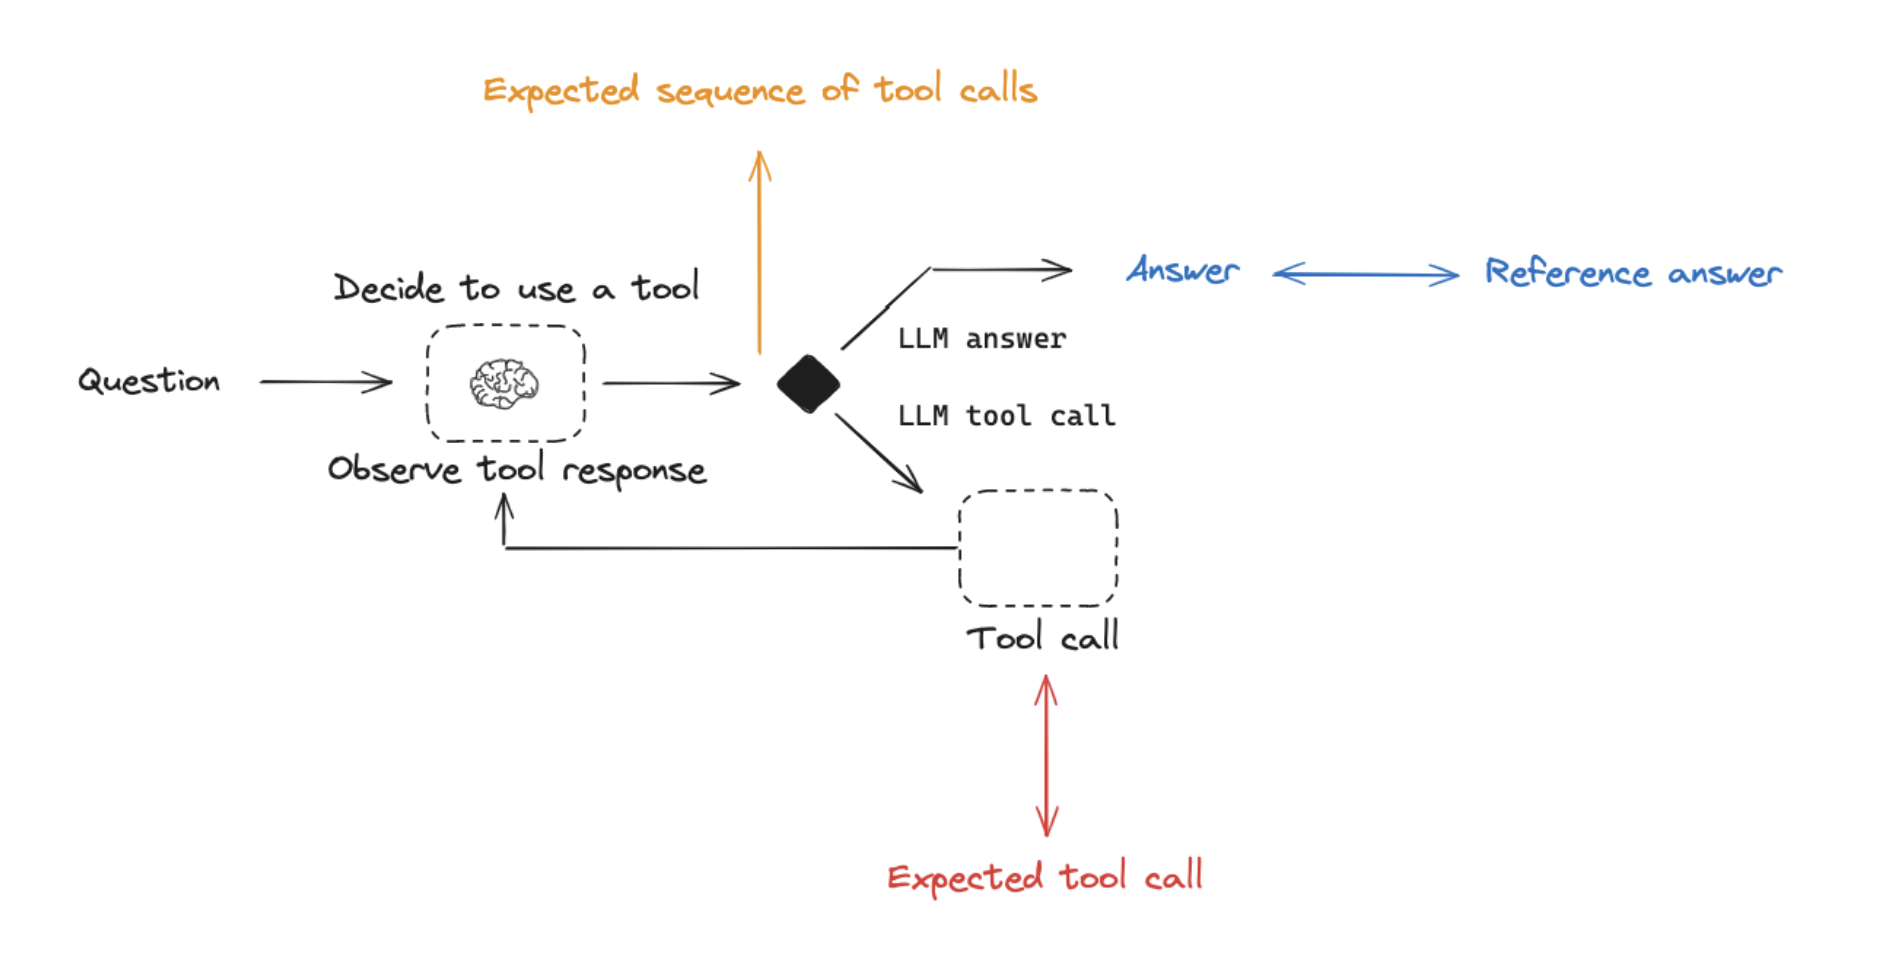